In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score  
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset,load_metric,concatenate_datasets
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [75]:
model_checkpoint = "motheecreator/vit-Facial-Expression-Recognition" # pre-trained model from which to fine-tune

In [5]:
from datasets import load_metric

metric = load_metric("accuracy")

In [7]:
from datasets import load_dataset

af_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/affectnet-training-data")

Resolving data files:   0%|          | 0/29043 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-1137b7173d2d8d4d/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
af_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 29042
    })
})

In [9]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined
# Get the label names
label_names = af_dataset['train'].features['label'].names

# Get the index of the 'contempt' label
contempt_index = label_names.index('contempt')

# Filter out the rows with 'contempt' label
filtered_dataset = af_dataset['train'].filter(lambda example: example['label'] != contempt_index)

# Remove 'contempt' from the label names
new_label_names = [name for name in label_names if name != 'contempt']

# Create a new ClassLabel feature without 'contempt'
new_label_feature = ClassLabel(names=new_label_names)

# Function to remap labels to the new indices
def remap_label(label):
    return new_label_feature.str2int(label_names[label])

# Update the dataset's label feature
filtered_dataset = filtered_dataset.map(lambda example: {'label': remap_label(example['label'])})

# Update the dataset features
filtered_dataset = filtered_dataset.cast_column('label', new_label_feature)

# Update the DatasetDict
af_dataset = DatasetDict({'train': filtered_dataset})

# Verify the change
print(af_dataset)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/26171 [00:00<?, ?ex/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [10]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined

# Get the label names
label_names = af_dataset['train'].features['label'].names

# Check if 'anger' exists in label_names before changing it
if 'anger' in label_names:
    # Change 'anger' to 'angry' in label names
    new_label_names = [name if name != 'anger' else 'angry' for name in label_names]

    # Update the label names in the dataset
    af_dataset['train'] = af_dataset['train'].rename_column('label', 'old_label')
    af_dataset['train'] = af_dataset['train'].rename_column('old_label', 'label')

    # Update the label 'anger' to 'angry' in the dataset
    af_dataset['train'] = af_dataset['train'].map(lambda example: {'label': 'angry' if example['label'] == 'anger' else example['label']})

    # Update the ClassLabel feature
    new_label_feature = ClassLabel(names=new_label_names)

    # Update the dataset's label feature
    af_dataset['train'] = af_dataset['train'].cast_column('label', new_label_feature)

# Verify the change
print(af_dataset)


  0%|          | 0/26171 [00:00<?, ?ex/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [11]:
fer_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/fer2013")

Resolving data files:   0%|          | 0/35887 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-def6d54d295f0c79/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
fer_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 35887
    })
})

In [13]:
mmi_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/mma-facial-expression")

Resolving data files:   0%|          | 0/127680 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-c2d8d45039dfd2cf/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
mmi_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 127680
    })
})

In [15]:
combined_dataset = concatenate_datasets([af_dataset['train'],fer_dataset['train'],mmi_dataset['train']])

In [16]:
dataset = DatasetDict()

In [17]:
dataset['train'] = combined_dataset

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 189738
    })
})

In [19]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

In [20]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=7, names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

In [21]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [22]:
label2id

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [23]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [24]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

Size:  224


In [25]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [26]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_data = splits['train']
val_data = splits['test']

In [27]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 151790
})

In [28]:
val_data

Dataset({
    features: ['image', 'label'],
    num_rows: 37948
})

In [29]:
train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)

In [30]:
train_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 5,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -

In [31]:
val_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 2,
 'pixel_values': tensor([[[ 0.0196,  0.0196,  0.0353,  ..., -0.6549, -0.6471, -0.6471],
          [ 0.0196,  0.0196,  0.0353,  ..., -0.6549, -0.6471, -0.6471],
          [ 0.0353,  0.0353,  0.0353,  ..., -0.6706, -0.6627, -0.6627],
          ...,
          [-0.8745, -0.8667, -0.8510,  ..., -0.7412, -0.7490, -0.7490],
          [-0.8824, -0.8745, -0.8431,  ..., -0.7490, -0.7647, -0.7647],
          [-0.8824, -0.8745, -0.8431,  ..., -0.7490, -0.7647, -0.7647]],
 
         [[-0.3412, -0.3412, -0.3255,  ..., -0.2471, -0.2392, -0.2392],
          [-0.3333, -0.3333, -0.3255,  ..., -0.2471, -0.2392, -0.2392],
          [-0.3255, -0.3255, -0.3176,  ..., -0.2627, -0.2549, -0.2549],
          ...,
          [-0.4431, -0.4510, -0.4667,  ..., -0.4431, -0.4510, -0.4510],
          [-0.4510, -0.4510, -0.4588,  ..., -0.4510, -0.4667, -0.4667],
          [-0.4510, -0.4510, -0.4510,  ..., -0.4510, -0.4667, -0.4667]],


In [32]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
notebook_login()

In [85]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)


In [35]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [36]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [86]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [87]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.354800,0.802372,0.741752
200,1.047000,0.682310,0.765310
300,0.939800,0.626422,0.782676
400,0.861800,0.585675,0.797302
500,0.836300,0.553183,0.810425
600,0.801800,0.527948,0.819595
700,0.756700,0.511048,0.824760
800,0.752100,0.507953,0.825946
900,0.741000,0.500245,0.827132
1000,0.722900,0.496713,0.826341


In [88]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.8434
  eval_loss               =     0.4503
  eval_runtime            = 0:05:39.84
  eval_samples_per_second =    111.662
  eval_steps_per_second   =       3.49


In [92]:
trainer.push_to_hub()

'https://huggingface.co/motheecreator/vit-Facial-Expression-Recognition/tree/main/'

In [90]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.45033568143844604, 'test_accuracy': 0.8434436597449141, 'test_runtime': 339.1549, 'test_samples_per_second': 111.89, 'test_steps_per_second': 3.497}


In [93]:
pipe=pipeline(model = 'motheecreator/vit-Facial-Expression-Recognition')

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

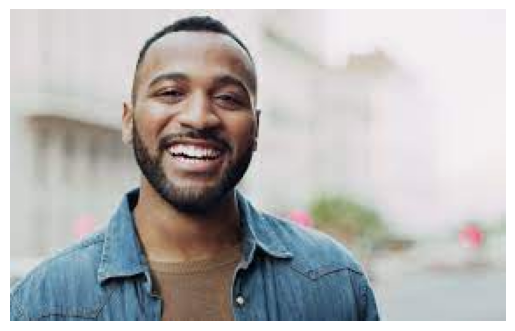

In [96]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image file
image_path = '/kaggle/input/testing-fer/testing_FER/happy2.jpg'  # Replace with the actual path to your image file
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [95]:
pipe("/kaggle/input/testing-fer/testing_FER/happy2.jpg")

[{'score': 0.9305050373077393, 'label': 'happy'},
 {'score': 0.04894712567329407, 'label': 'surprise'},
 {'score': 0.008805845864117146, 'label': 'neutral'},
 {'score': 0.005610967520624399, 'label': 'disgust'},
 {'score': 0.0027375691570341587, 'label': 'sad'}]

Accuracy: 0.8434
F1 Score: 0.7952


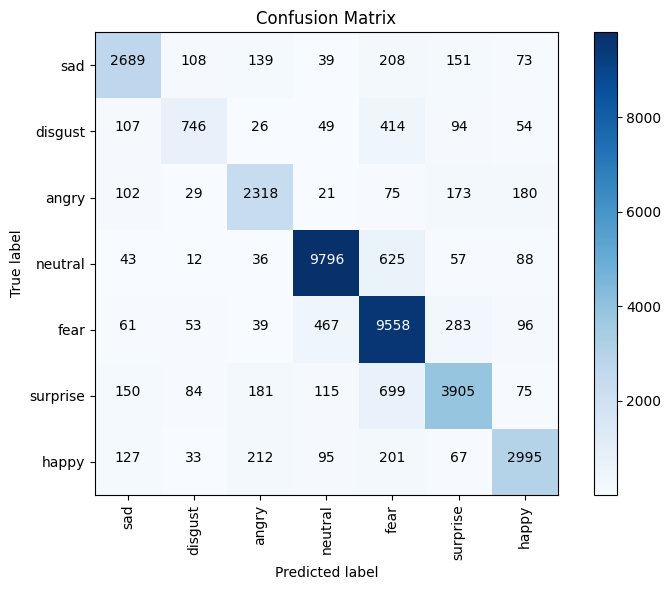


Classification report:

              precision    recall  f1-score   support

         sad     0.8201    0.7893    0.8044      3407
     disgust     0.7005    0.5007    0.5840      1490
       angry     0.7855    0.7999    0.7926      2898
     neutral     0.9257    0.9192    0.9225     10657
        fear     0.8114    0.9054    0.8558     10557
    surprise     0.8256    0.7497    0.7858      5209
       happy     0.8411    0.8029    0.8216      3730

    accuracy                         0.8434     37948
   macro avg     0.8157    0.7810    0.7952     37948
weighted avg     0.8428    0.8434    0.8414     37948



In [91]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))